<a href="https://colab.research.google.com/github/Lenguist/insight-game-ai/blob/main/simple_sim_united.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description moved to readme

# Simulation code (only know # of turns)


In [13]:
from simulations import basic_simulation
from sellers import RandomSeller
from sellers import DescentArithmeticSeller
imp_list = [i / 10.0 for i in range(11)]
all_results = []

# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 30
rounds = 10000
init_offer=range_max

# random agent
random_results = []
seller = RandomSeller(value=value, init_offer=init_offer)
for imp_incr in imp_list:
  result = basic_simulation(value,
                        range_min,
                        range_max,
                        imp_incr = imp_incr,
                        imp_init = 0,
                        rounds = rounds,
                        seller=seller)
  random_results.append(result)

# simple heuristic agent, consistently performs better than random
arithmetic_results = []
n = int((init_offer-value)/2)
seller = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent = n)
for imp_incr in imp_list:
  result = basic_simulation(value,
                        range_min,
                        range_max,
                        imp_incr = imp_incr,
                        imp_init = 0,
                        rounds = rounds,
                        seller=seller)
  arithmetic_results.append(result)

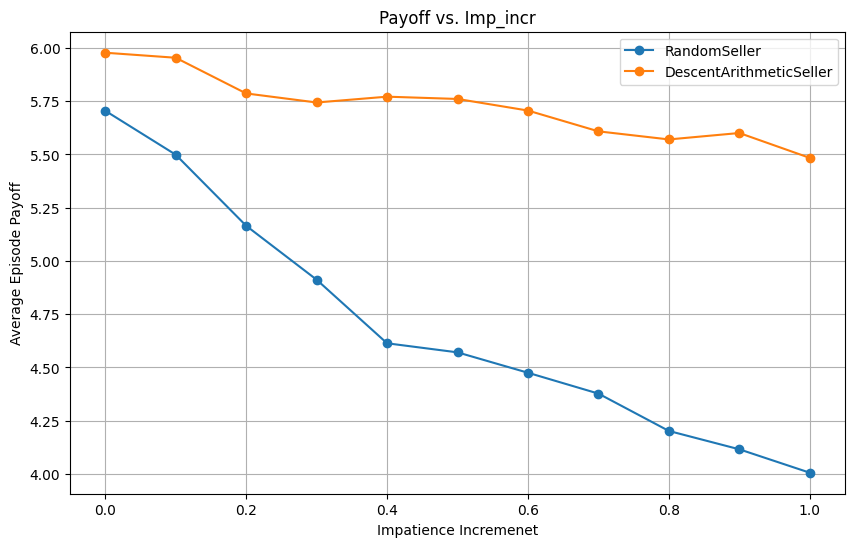

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(imp_list, random_results, marker='o', label=f'RandomSeller')
plt.plot(imp_list, arithmetic_results, marker='o', label=f'DescentArithmeticSeller')
plt.title('Payoff vs. Imp_incr')
plt.xlabel('Impatience Incremenet')
plt.ylabel('Average Episode Payoff')
plt.grid()

plt.legend()  # This will create a legend using the labels specified in the plot functions

plt.show()

In [15]:
from simulations import *
imp_list = [i / 10.0 for i in range(11)]
all_results = []

# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 30
rounds = 10000
init_offer=range_max

# random agent
seller = RandomSeller(value=value, init_offer=init_offer)
random_results = random_imp_simulation(value,
                        range_min,
                        range_max,
                        rounds = rounds,
                        seller=seller)

# simple heuristic agent, consistently performs better than random
n = int((init_offer-value)/2)
seller = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent = n)
arithmetic_results = random_imp_simulation(value,
                        range_min,
                        range_max,
                        rounds = rounds,
                        seller=seller)

In [16]:
# random agent random impatience results
random_results

4.5894

In [17]:
# arithmetic agent random impatience result
arithmetic_results

5.5963

In [18]:
mean_list = [i/10.0 for i in range(11)]
all_results = []

# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 30
rounds = 100000
init_offer=range_max

# random agent
random_results = []
seller = RandomSeller(value=value, init_offer=init_offer)
for mean in mean_list:
  result = normal_imp_simulation(value,
                        range_min,
                        range_max,
                        mean = mean,
                        rounds = rounds,
                        seller=seller)
  random_results.append(result)

# simple heuristic agent, consistently performs better than random
arithmetic_results = []
n = int((init_offer-value)/2)
seller = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent = n)
for mean in mean_list:
  result = normal_imp_simulation(value,
                        range_min,
                        range_max,
                       mean = mean,
                        rounds = rounds,
                        seller=seller)
  arithmetic_results.append(result)

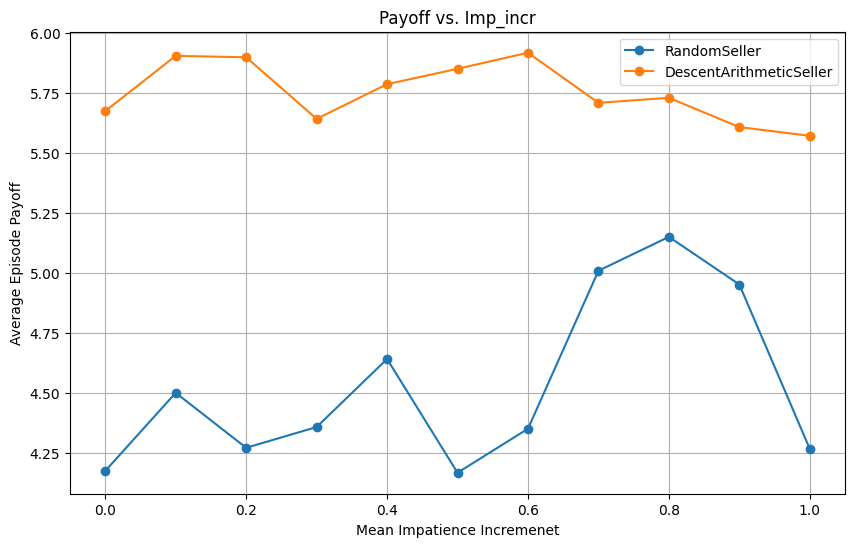

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mean_list, random_results, marker='o', label=f'RandomSeller')
plt.plot(mean_list, arithmetic_results, marker='o', label=f'DescentArithmeticSeller')
plt.title('Payoff vs. Imp_incr')
plt.xlabel('Mean Impatience Incremenet')
plt.ylabel('Average Episode Payoff')
plt.grid()

plt.legend()  # This will create a legend using the labels specified in the plot functions

plt.show()

# Two sellers

In [19]:
"""
Simplest scenario
"""

''